#  Edge Graph Convolutional NN for Jet anomaly (variational) autoencoder  using jet constituents from offline delphes data


In [1]:
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import setGPU
from importlib import reload

setGPU: Setting GPU to: 1


In [2]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

import models.models as models
reload(models)
import models.losses as losses
reload(losses)
import utils.preprocessing as prepr
reload(prepr)

Using TensorFlow backend.


<module 'utils.preprocessing' from '/eos/home-n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/preprocessing.py'>

In [3]:
DATA_PATH = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/input/'
filename_bg = DATA_PATH + 'QCD_training_data_02_08_2021.h5'
inFile = h5py.File(filename_bg, 'r')
particles_bg = inFile['particle_bg'][0:int(5*10e3)]
particles_bg_valid = inFile['particle_bg_valid'][0:int(1*10e3)]
particles_bg_test = inFile['particle_bg_test'][0:int(1*10e3)]
nodes_n = particles_bg.shape[1]
feat_sz = particles_bg.shape[2]

In [25]:
#signal
DATA_PATH = '/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_data/events/'

res_width = 'BROAD,NARROW'.split(',')
res_mass = '1.5,3.5'.split(',')
particles_sig_dict = {}

for width in res_width:
    for mass in res_mass:  
        SIG_NAME = 'RSGraviton_WW_'+width+'_13TeV_PU40_'+mass+'TeV_NEW'
        filename_sig = DATA_PATH + SIG_NAME + '_parts/' + SIG_NAME + '_concat_001.h5'
        _,_, particles_sig = prepr.prepare_data_constituents(filename_sig,5000,0,5000)
        particles_sig_dict['Graviton '+width+' '+mass] = particles_sig
signal_types = list(particles_sig_dict.keys())  

Number of jets = 9890
Number of constituents (nodes) = 50
Number of features = 3
Number of jets = 9969
Number of constituents (nodes) = 50
Number of features = 3
Number of jets = 9854
Number of constituents (nodes) = 50
Number of features = 3
Number of jets = 9966
Number of constituents (nodes) = 50
Number of features = 3


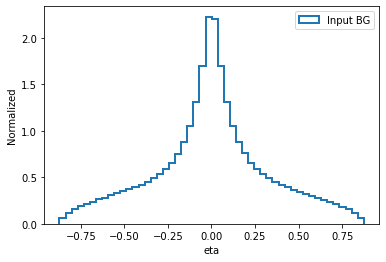

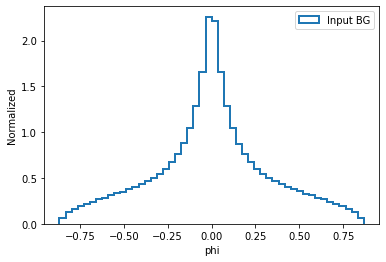

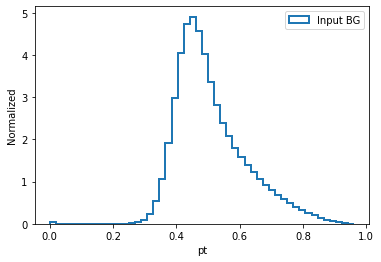

In [4]:
feats = 'eta,phi,pt'.split(',')
for i in range(0,3):
    xmin = np.quantile(particles_bg[:,:,i].flatten(),0.05)
    xmax = np.quantile(particles_bg[:,:,i].flatten(),0.98)
    plt.figure()
    plt.hist(particles_bg[:,:,i].flatten(), bins=50, label='Input BG', density=True, histtype='step', fill=False, linewidth=2)
    plt.xlabel(feats[i])
    plt.ylabel("Normalized")
    plt.legend(loc='upper right')
    #plt.semilogy()
    plt.show()

## Define KNN algorithm to find nearest node neightbours 

In [5]:


# A shape is (N, P_A, C), B shape is (N, P_B, C)
# D shape is (N, P_A, P_B)
def batch_distance_matrix_general(A, B):
    with tf.name_scope('dmat'):
        r_A = tf.reduce_sum(A * A, axis=2, keepdims=True)
        r_B = tf.reduce_sum(B * B, axis=2, keepdims=True)
        m = tf.matmul(A, tf.transpose(B, perm=(0, 2, 1)))
        D = r_A - 2 * m + tf.transpose(r_B, perm=(0, 2, 1))
        return D


def knn(num_points, k, topk_indices, features):
    # topk_indices: (N, P, K)
    # features: (N, P, C)
    with tf.name_scope('knn'):
        queries_shape = tf.shape(features)
        batch_size = queries_shape[0]
        batch_indices = tf.tile(tf.reshape(tf.range(batch_size), (-1, 1, 1, 1)), (1, num_points, k, 1))
        indices = tf.concat([batch_indices, tf.expand_dims(topk_indices, axis=3)], axis=3)  # (N, P, K, 2)
        return tf.gather_nd(features, indices)


def knn_diff(X,K):
    """EdgeConv
    Args:
        K: int, number of neighbors
    Inputs:
        X: point features (eta, phi, Pt)
    Returns:
        neighbours features differences
    """

    # Define node coordinates and features ( original ParticleNET uses only Pt as node features ! )
    pts = X[:,:,1:3] # (Eta,Phi) coordinates of points ( graph nodes )
    fts = X          # (Pt,Eta,Phi) node features ( graph node features )
    num_points = X.shape[1]

    # distance
    D = batch_distance_matrix_general(pts, pts)  # (N, P, P)
    _, indices = tf.nn.top_k(-D, k=K + 1)  # (N, P, K+1)
    indices = indices[:, :, 1:]  # (N, P, K)

    # Finds nodes nearest neighbours features differences
    knn_fts = knn(num_points, K, indices, fts)  # (N, P, K, C)
    knn_fts_center = tf.tile(tf.expand_dims(fts, axis=2), (1, 1, K, 1))  
    knn_fts = tf.subtract(knn_fts, knn_fts_center)  # (N, P, K, C)

    return knn_fts



## Define EdgeGraphConv Model 

EdgeGraphConv implements a modified version of DGCNN where we use a Conv1D instead of a Conv2D in order to define the convolution over the graph nodes and edges. Notice that a Conv1D layer uses a kernel_size=1 and stride=1 over the nodes(edges), so it's equivalent to apply a MLP to agregate the  nodes(edges) features. In Spektral EdgeConv uses directly an MLP for that. 

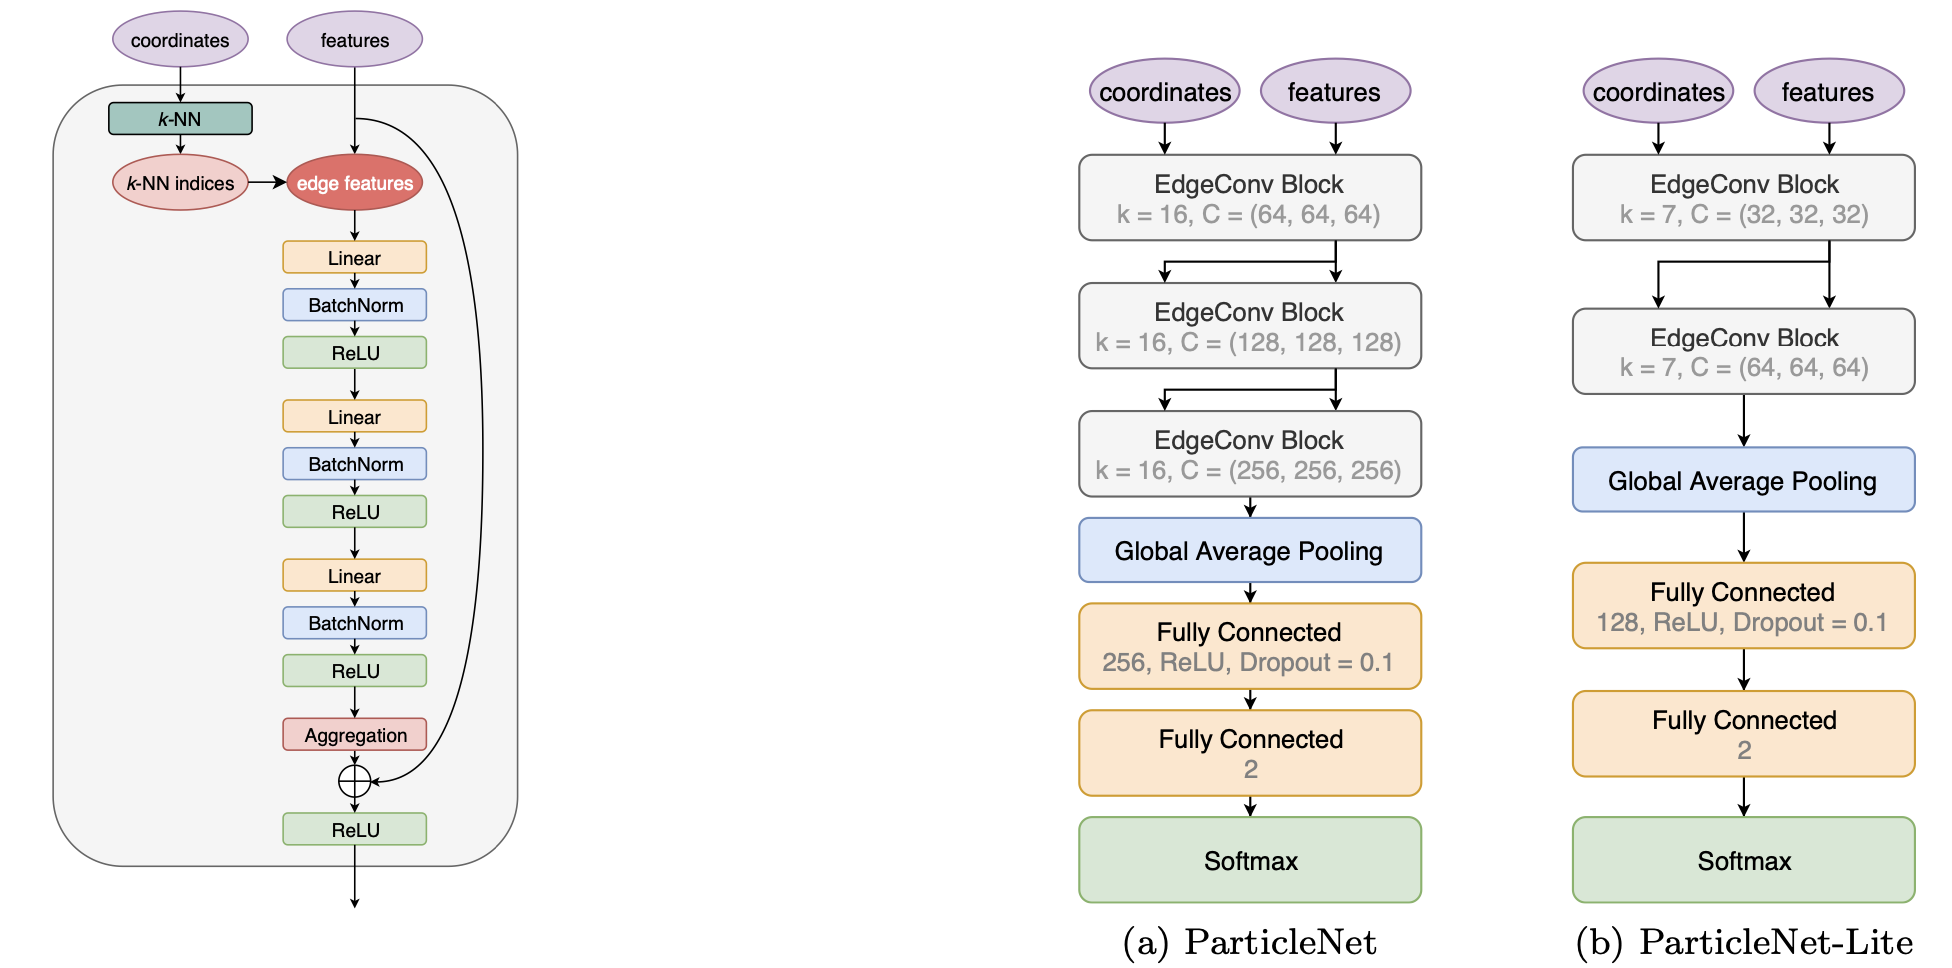


In [6]:
# baseline keras model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD, Adam, Nadam
from tensorflow.keras.layers import BatchNormalization, MaxPool1D, Conv1D
from tensorflow.keras.layers import Input, Activation, Dense, Flatten , LeakyReLU
from tensorflow.keras import utils

import models.layers as lays
reload(lays)


<module 'models.layers' from '/eos/home-n/nchernya/MLHEP/AnomalyDetection/ADgvae/models/layers.py'>

In [35]:
import models.models as models
reload(models)
nhidden = 10 #int(nodes_n*feat_sz/10) 

k=7
ae = models.EdgeConvAutoEncoder(nodes_n=nodes_n, feat_sz=feat_sz, k_neighbors=k, activation=LeakyReLU(alpha=0.1),latent_dim=nhidden)
#vae = models.EdgeConvVariationalAutoEncoder(nodes_n=nodes_n, feat_sz=feat_sz,k_neighbors=k, activation=LeakyReLU(alpha=0.1),
 #                               latent_dim=nhidden,beta_kl=10,kl_warmup_time=5)

Model: "EdgeConvEncoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
in_points (InputLayer)          [(None, 50, 3)]      0                                            
__________________________________________________________________________________________________
in_edges (InputLayer)           [(None, 50, 21)]     0                                            
__________________________________________________________________________________________________
BatchNorm_points (BatchNormaliz (None, 50, 3)        12          in_points[0][0]                  
__________________________________________________________________________________________________
BatchNorm_edges (BatchNormaliza (None, 50, 21)       84          in_edges[0][0]                   
____________________________________________________________________________________

## Run training
Here, we run the training.

In [38]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
import setGPU 

optim = Adam(learning_rate=0.001)
ae.compile(optimizer=optim, run_eagerly=True)
#vae.compile(optimizer=optim, run_eagerly=True) 

In [55]:
# early stopping callback
es = EarlyStopping(monitor='val_loss', patience=5,verbose=2)

# Learning rate scheduler 
ls = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5,verbose=2)

kl_beta_callback = models.KLWarmupCallback()   

# Training data 
diffs_train = knn_diff(particles_bg,k) # (batch,constit,k_neighbour,feat_diff)
edge_feats_train = tf.reshape(diffs_train,[-1,nodes_n,k*feat_sz])   # reshape edges (N,nconstit*K*nfeat)

# Validation data 
diffs_valid = knn_diff(particles_bg_valid,k) # (batch,constit,k_neighbour,feat_diff)
edge_feats_valid = tf.reshape(diffs_valid,[-1,nodes_n,k*feat_sz])   # reshape edges (N,nconstit*K*nfeat)

print("point_feats shape= ",particles_bg.shape)
print("edge_feats shape= ",edge_feats_train.shape)

#vae or ae
history = ae.fit((particles_bg, edge_feats_train) , particles_bg,
                    validation_data = ((particles_bg_valid, edge_feats_valid) , particles_bg_valid),
                    epochs=40, 
                    batch_size=256, 
                    verbose=1,
                    callbacks=[es,ls]) #,kl_beta_callback
                   # callbacks=[es,ls,kl_beta_callback])



point_feats shape=  (50000, 50, 3)
edge_feats shape=  (50000, 50, 21)
Epoch 1/40
196/196 [==============================] - 5s 23ms/step - val_loss: 0.0262
Epoch 2/40
196/196 [==============================] - 4s 23ms/step - val_loss: 0.0260
Epoch 3/40
196/196 [==============================] - 5s 23ms/step - val_loss: 0.0259
Epoch 4/40
196/196 [==============================] - 4s 23ms/step - val_loss: 0.0261
Epoch 5/40
196/196 [==============================] - 4s 23ms/step - val_loss: 0.0261
Epoch 6/40
196/196 [==============================] - 4s 23ms/step - val_loss: 0.0255
Epoch 7/40
196/196 [==============================] - 5s 23ms/step - val_loss: 0.0260
Epoch 8/40
196/196 [==============================] - 4s 23ms/step - val_loss: 0.0261
Epoch 9/40
196/196 [==============================] - 4s 23ms/step - val_loss: 0.0261
Epoch 10/40
196/196 [==============================] - 4s 23ms/step - val_loss: 0.0260
Epoch 11/40
196/196 [==============================] - ETA: 0s
Epoch 

In [56]:
diffs_bg_test = knn_diff(particles_bg_test,k) # (batch,constit,k_neighbour,feat_diff)
edge_feats_bg_test = tf.reshape(diffs_bg_test,[-1,nodes_n,k*feat_sz])   # reshape edges (N,nconstit*K*nfeat)
Y_bg_predict = ae.predict((particles_bg_test,edge_feats_bg_test))

particles_sig_dict['predicted'] = {}
for sig in signal_types:
    particles_sig = particles_sig_dict[sig]
    diffs_sig = knn_diff(particles_sig,k) # (batch,constit,k_neighbour,feat_diff)
    edge_feats_sig = tf.reshape(diffs_sig,[-1,nodes_n,k*feat_sz])   # reshape edges (N,nconstit*K*nfeat
    particles_sig_dict['predicted'][sig]= ae.predict((particles_sig,edge_feats_sig))

#particles_sig = particles_sig_dict[signal_types[0]]
#diffs_sig = knn_diff(particles_sig,k) # (batch,constit,k_neighbour,feat_diff)
#edge_feats_sig = tf.reshape(diffs_sig,[-1,nodes_n,k*feat_sz])   # reshape edges (N,nconstit*K*nfeat

In [57]:
#Y_bg_predict = ae.predict([particles_bg_test,edge_feats_bg_test])
#Y_sig_predict = ae.predict([particles_sig,edge_feats_sig])

In [58]:
#Y_bg_predict, _, _, _ = vae.predict((particles_bg_test,edge_feats_bg_test))
#Y_sig_predict, _, _, _ = vae.predict((particles_sig,edge_feats_sig))



## Plot performance
Here, we plot the history of the training and the performance in a ROC curve

In [59]:
loss_bg = losses.threeD_loss_manual(particles_bg_test,Y_bg_predict)
#loss_sig = losses.threeD_loss_manual(particles_sig,Y_sig_predict)

particles_sig_dict['loss'] = {}
for sig in signal_types:
    particles_sig_dict['loss'][sig] = losses.threeD_loss_manual(particles_sig_dict[sig],particles_sig_dict['predicted'][sig])


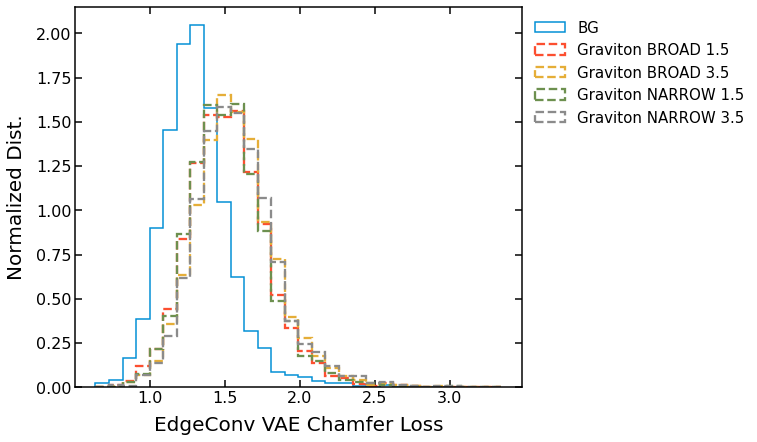

In [60]:
figures_save = 'reco_edgeconv_vae_latent5'
fig_dir = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/figs/'

plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')

max_score = np.quantile(loss_sig,0.99)#,np.max(loss_bg_dist))
min_score = np.min(loss_bg)#,np.max(loss_bg_dist))
bins = 30
# plot BG
plt.figure()
plt.hist(loss_bg, bins=bins, label='BG', density=True, range=(min_score, max_score), 
         histtype='step', fill=False, linewidth=1.5)
for sig in signal_types:
    plt.hist(particles_sig_dict['loss'][sig], bins=bins, label=sig, density=True, range=(min_score, max_score), 
         histtype='step', linestyle='--',fill=False, linewidth=2.3)
#plt.semilogy()
plt.xlabel("EdgeConv VAE Chamfer Loss")
plt.ylabel("Normalized Dist.")
plt.legend(bbox_to_anchor=(1., 1.),fontsize=15)
savename = fig_dir+'loss_{}.pdf'.format(figures_save)
plt.savefig(savename)
plt.show()

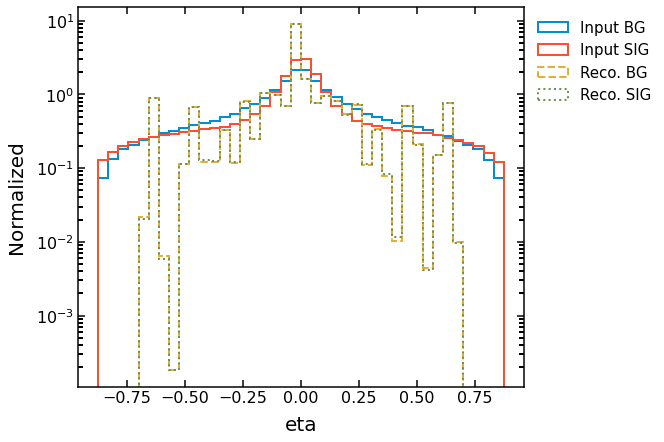

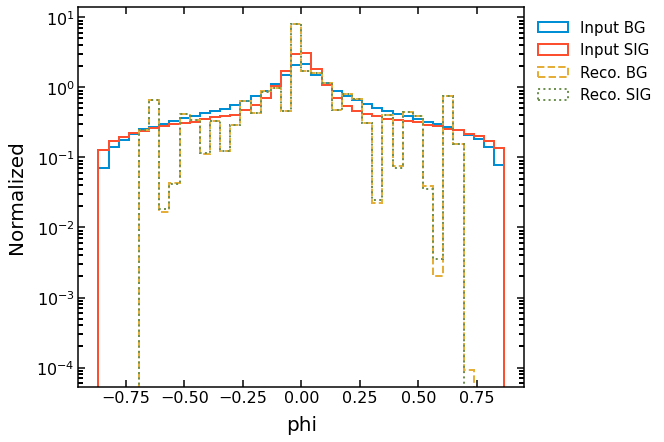

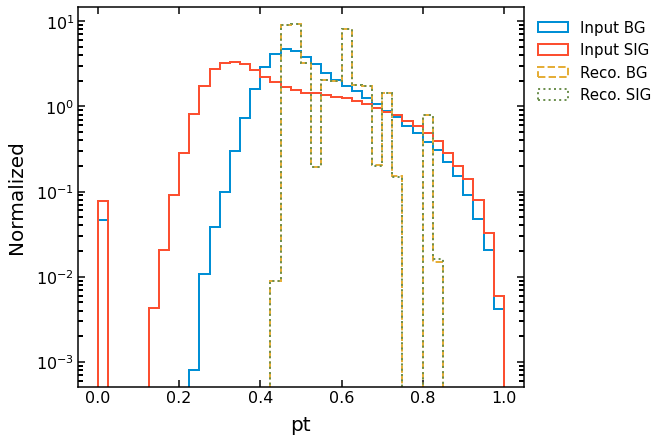

In [58]:
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')
for i in range(0,len(feats)):
    #xmin = np.quantile(particles_bg[:,:,i].flatten(),0.)
    #xmax = np.quantile(particles_bg[:,:,i].flatten(),1)
    xmin = np.min([np.min(particles_bg[:,:,i].flatten()),np.min(Y_bg_predict[:,:,i].flatten())])
    xmax = np.max([np.max(particles_bg[:,:,i].flatten()),np.max(Y_bg_predict[:,:,i].flatten())])
    n_bins = 40
    plot_range = (xmin,xmax)
    plt.figure()
    _,bins,_ = plt.hist(particles_bg_test[:,:,i].flatten(), bins=n_bins, range = plot_range,label='Input BG', density=True, histtype='step', fill=False, linewidth=2)
    _,_,_ = plt.hist(particles_sig[:,:,i].flatten(), bins=bins, label='Input SIG',density=True, histtype='step', fill=False, linewidth=2)
    _,_,_ = plt.hist(Y_bg_predict[:,:,i].flatten(), bins=bins, label='Reco. BG', linestyle='--',density=True, histtype='step', fill=False, linewidth=2)
    _,_,_ = plt.hist(Y_sig_predict[:,:,i].flatten(), bins=bins, label='Reco. SIG', linestyle=':',density=True, histtype='step', fill=False, linewidth=2)
    plt.xlabel(feats[i])
    plt.ylabel("Normalized")
    plt.legend(bbox_to_anchor=(1., 1.),fontsize=15)
    plt.semilogy()
    savename = fig_dir+'{}_{}.pdf'.format(feats[i],figures_save)
    plt.savefig(savename)
    plt.show()

In [52]:
sys.path.append(os.path.abspath(os.path.join('../../vande/')))
sys.path.append(os.path.abspath(os.path.join('../../pofah/')))
sys.path.append(os.path.abspath(os.path.join('../../sarewt/')))
sys.path.append(os.path.abspath(os.path.join('../../')))

In [53]:
import vande.analysis.analysis_roc as ar
reload(ar)

<module 'vande.analysis.analysis_roc' from '/eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/analysis/analysis_roc.py'>

/eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/analysis/analysis_roc.py:33: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(tpr, 1./fpr, label=label + " (auc " + "{0:.3f}".format(aucs[-1]) + ")")
/eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/analysis/analysis_roc.py:33: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(tpr, 1./fpr, label=label + " (auc " + "{0:.3f}".format(aucs[-1]) + ")")
/eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/analysis/analysis_roc.py:33: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(tpr, 1./fpr, label=label + " (auc " + "{0:.3f}".format(aucs[-1]) + ")")
/eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/analysis/analysis_roc.py:33: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(tpr, 1./fpr, label=label + " (auc " + "{0:.3f}".format(aucs[-1]) + ")")


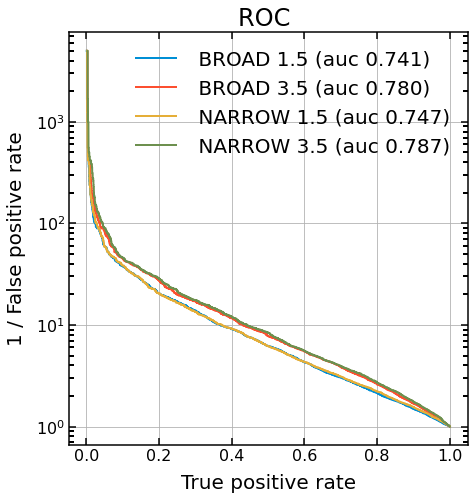

[0.7413572799999999, 0.77977834, 0.7468188999999998, 0.7870927400000001]

In [61]:
neg_class_losses = [loss_bg.tolist()]*len(signal_types)
pos_class_losses = []
for sig in signal_types:
    pos_class_losses.append(particles_sig_dict['loss'][sig])

plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')
ar.plot_roc( neg_class_losses, pos_class_losses, legend=[sig.replace('Graviton','') for sig in signal_types], title='ROC ',
            plot_name='ROC_pn_ae_signals', fig_dir='/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/figs/',log_x=False )


In [62]:
print('h')

h
